<a href="https://colab.research.google.com/github/AntiPersnlMyne/RIT_CIS_ISAM/blob/main/RIT_ISAM_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 1

In [ ]:
!pip install opencv-python
!pip install matplotlib
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from google.colab.patches import cv2_imshow
import scipy
import math

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### If needed, recreate averaged images

In [ ]:
# Search for TIFF files in Project2 directory
filenames = []
for name in glob("/content/drive/Shareddrives/ISAM/Project2/**/*.tiff"):
  filenames.append(name)

# Sort results
filenames.sort()

In [ ]:
# Create list of TIFF files. Each index is 1/5 files for that f#.
# Images read in as grayscale
iso_chart_images = [cv.imread(file, cv.IMREAD_GRAYSCALE) for file in filenames]

Image shape: (561, 1058)


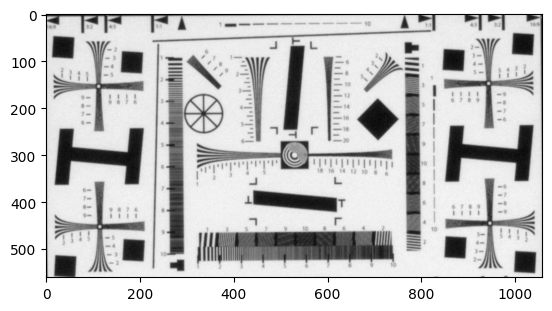

In [ ]:
# Grab first image from each f/# as crop reference
crop_reference = iso_chart_images[0]

# Crop the images
crop_reference = crop_reference[1375:-1540, 2085:-2065]

# Verify results
plt.imshow(crop_reference, cmap=mpl.colormaps["gray"])

img_height, img_width = crop_reference.shape
print(f"Image shape: {(img_height, img_width)}")

In [ ]:
# Crop the images
iso_chart_images = [image[1375:-1540, 2085:-2065] for image in iso_chart_images]

In [ ]:
# Create orb detecotr with 5000 features
orb_detector = cv.ORB_create(5000)

In [ ]:
# Base/reference image to register to
iso_ref = iso_chart_images[0]

keypoint_ref, descriptor_ref = orb_detector.detectAndCompute(iso_ref, None)

# Create output buffer
registered_iso_chart = np.zeros((img_height, img_width), dtype=np.float64)

# Add first image (the referfence) as first in final stack
registered_iso_chart[:,:] += iso_ref[:]

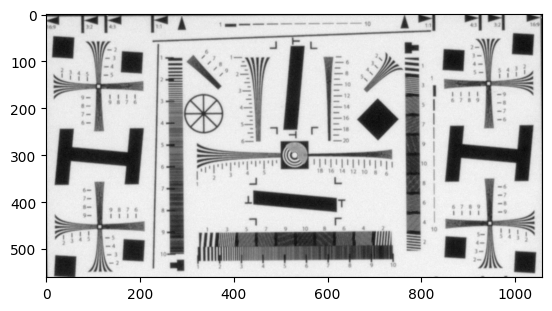

In [ ]:
# 4 remaining images in each f/#
for i in range(1, 5):

  # Define the images being registered
  # TBR = To Be Registered
  tbr = iso_chart_images[i]

  # Find (imageKeypoints (kp), imageDescriptors (desc)) for each image
  keypoints, descriptors = orb_detector.detectAndCompute(tbr, None)

  # Match features between the two images
  matcher = cv.BFMatcher()
  matches = matcher.match(descriptor_ref, descriptors)

  # Sort matches by relevance
  matches = sorted(matches, key=lambda x: x.distance)

  # take the top 90% of matches
  matches = matches[:int(len(matches)*0.9)]

  # Number of matches for each image
  n_matches = len(matches)

  # Define empty matrices of shape (nmatches, 2)
  p1 = np.zeros((n_matches, 2))

  p2 = np.zeros((n_matches, 2))

  # Append registered image to final image stack
  for i in range(n_matches):
    p1[i, :] = keypoints[matches[i].trainIdx].pt

    p2[i, :] = keypoint_ref[matches[i].queryIdx].pt

  # Find the homography matrix
  homography_mat, mask_f22 = cv.findHomography(p1, p2, cv.RANSAC)

  # Use transformation matrix to transform the image
  transformed_chart_img = cv.warpPerspective(
      tbr, homography_mat, (img_width, img_height),
  )

  # Append transformed image to image stack
  registered_iso_chart += transformed_chart_img

  plt.imshow(transformed_chart_img, cmap=mpl.colormaps["gray"])


In [ ]:
registered_iso_chart /= 5
registered_iso_chart = registered_iso_chart.astype(np.float64)

In [ ]:
cv.imwrite("/content/drive/Shareddrives/ISAM/Project2/registered_f22.png", registered_iso_chart)

True

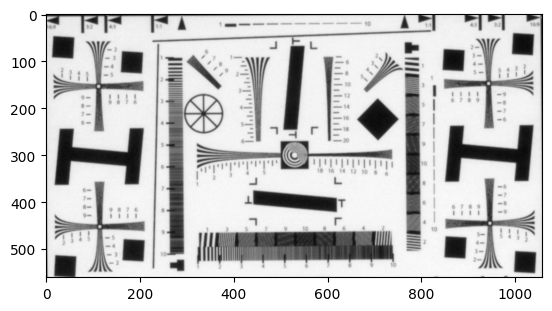

In [ ]:
plt.imshow(registered_iso_chart, cmap=mpl.colormaps['gray'])

### Part 2

In [ ]:
# Call on chart
registered_iso_chart = cv.imread("/content/drive/Shareddrives/ISAM/Project2/registered_f22.png", cv.IMREAD_GRAYSCALE)
# Normalize image
print("Pre norm min", np.min(registered_iso_chart))
print("Pre norm max", np.max(registered_iso_chart))

# Normalize [0,1]
normalized_iso_chart = ((registered_iso_chart - registered_iso_chart.min()) \
           / (registered_iso_chart.max() - registered_iso_chart.min()))

# Validate
print("min", np.min(normalized_iso_chart))
print("max", np.max(normalized_iso_chart))

# Save
cv.imwrite("/content/drive/Shareddrives/ISAM/Project2/norm_22.png", normalized_iso_chart)

Pre norm min 62
Pre norm max 243
min 0.0
max 1.0


True

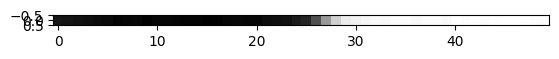

In [ ]:
# Get edge spread of slanted line
plt.imshow(normalized_iso_chart[120:121,520:570], cmap=mpl.colormaps["gray"])
# If we need to rerun, 5.6 is 525-575, other 2 are 520-570
edge_spread_func = normalized_iso_chart[120:121,520:570]

# Convert ESF to a vector
# Remove extra dimension (1,N) -> (N)
edge_spread_func = np.squeeze(edge_spread_func).astype(np.float64)

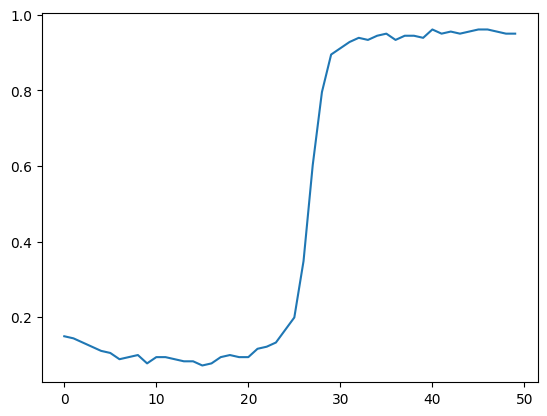

In [ ]:
plt.plot(edge_spread_func)

### Part 3

Compute LSF

In [ ]:
# Differentiate ESF vector to estimate LSF
line_spread_func = np.gradient(edge_spread_func)

# Clip negative valued: [0,1]
dif_line_22 = line_spread_func.clip(0.0,1.0)

# Peak normalize
line_spread_func /= line_spread_func.max()

Curve fitting with Guassian

In [ ]:
# Initial guesses
amp = line_spread_func.max()                   # 1 after normalization
mu = np.argmax(line_spread_func)               # peak location
sigma = len(line_spread_func) / 10             # rough width guess
off = np.min(line_spread_func)                 # baseline

initial_guess = [amp, mu, sigma, off]


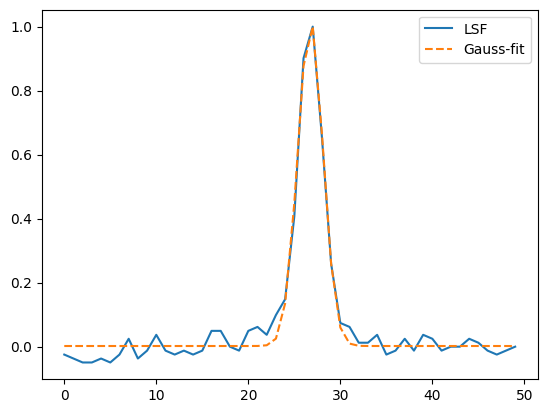

In [ ]:
# Define Gaussian function
def gaussian(x, amplitude, mean, stdev, offset):
  return amplitude * np.exp(-(x-mean)**2 / (2*stdev**2)) + offset

# x-data
x_axis = np.arange(len(line_spread_func))

# Fit Gaussian
parameters, _ = scipy.optimize.curve_fit(
    gaussian,
    xdata=x_axis,
    ydata=line_spread_func,
    p0=initial_guess, # initial curve params guess
)
fit_amplitude, fit_mean, fit_stdev, fit_offset = parameters
gaussian_fit = gaussian(x_axis, fit_amplitude, fit_mean, fit_stdev, fit_offset)

# Display curve-fit
plt.plot(line_spread_func)
plt.plot(gaussian_fit, linestyle="--")
plt.legend(["LSF", "Gauss-fit"])

Report mean and stddev of fit curve

In [ ]:
print(f"Mean: {fit_mean:.4f}\nStddev: {fit_stdev:.4f}")

Mean: 26.7440
Stddev: 1.3599


### Part 4

In [ ]:
# (re)Naming clarity
sigma = fit_stdev

# PDF domain
axis = np.linspace(-3*sigma, 3*sigma, num=200)
x_grid, y_grid = np.meshgrid(axis, axis, indexing="xy")


In [ ]:
# Define PSF
def PSF(x_space, y_space, sigma):
  """Gaussian PSF evaluated on a 2D grid"""
  # Constant
  a = 1.0 / (2.0 * np.pi * sigma ** 2)

  # PSF equation
  return a * np.exp(-(x_space ** 2 + y_space ** 2) / (2.0 * sigma ** 2))

<function matplotlib.pyplot.show(close=None, block=None)>

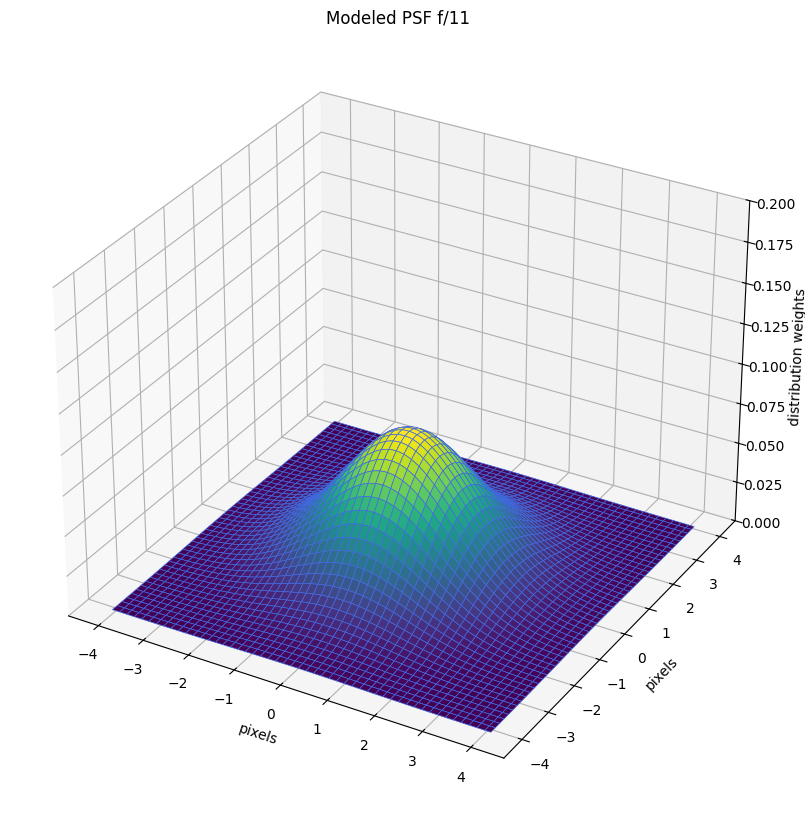

In [ ]:
psf = PSF(x_grid, y_grid, sigma)

# Display curve-fit
fig = plt.figure(figsize=(10,16))
ax = plt.axes(projection='3d')

# Plot the 3D surface
ax.plot_surface(x_grid, y_grid, psf,
                edgecolor='royalblue', lw=0.5, rstride=4, cstride=4, alpha=1.0,
                cmap="viridis")

ax.set_zlim([0,0.2])
ax.set_title("Modeled PSF f/11")
ax.set_xlabel("pixels")
ax.set_ylabel("pixels")
ax.set_zlabel("distribution weights")

plt.show

### Part 5

Define the kernel

In [ ]:
# Define a (integer) kernel
half_width = math.ceil(3*sigma)
kernel_size = 2 * half_width + 1
gaus_kernel = np.zeros((kernel_size,kernel_size), dtype=np.float64)

# Integer domain
axis = np.linspace(-half_width, half_width, kernel_size)
x_grid, y_grid = np.meshgrid(axis, axis, indexing='xy')

# Populate the kernel
kernel = PSF(x_grid, y_grid, sigma)
kernel /= kernel.sum() # normalize

Plot the kernel

<function matplotlib.pyplot.show(close=None, block=None)>

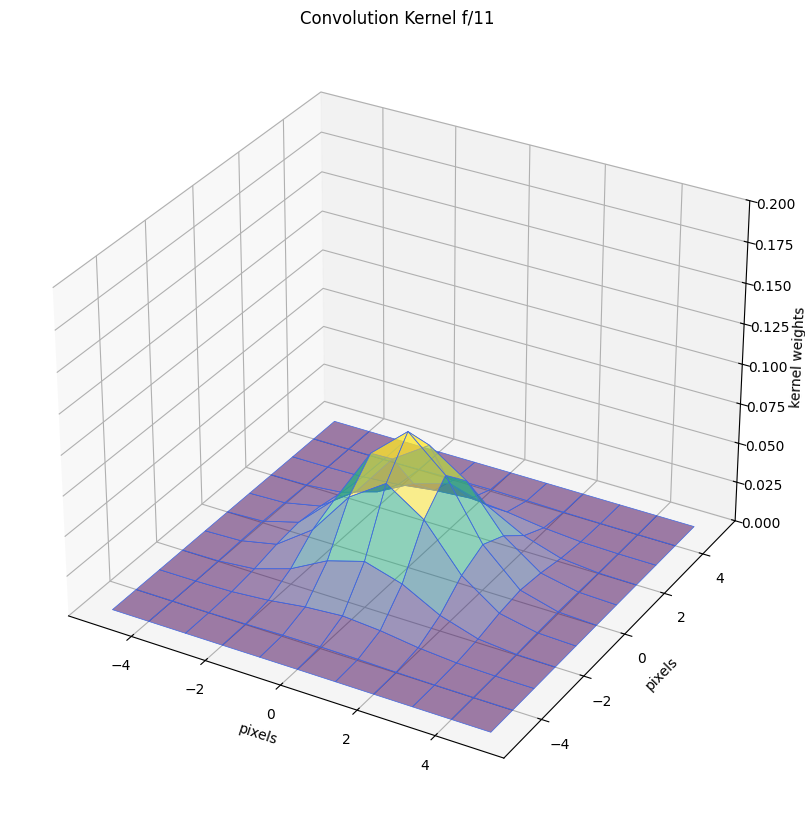

In [ ]:
# Display curve-fit
fig = plt.figure(figsize=(10,16))
ax = plt.axes(projection="3d")

# Plot the 3D surface
ax.plot_surface(x_grid, y_grid, kernel,
                edgecolor='royalblue', lw=0.5, rstride=1, cstride=1, alpha=0.5,
                cmap="viridis")

ax.set_zlim([0,0.2])
ax.set_title("Convolution Kernel f/11")
ax.set_xlabel("pixels")
ax.set_ylabel("pixels")
ax.set_zlabel("kernel weights")

plt.show

### Part 6

In [ ]:
# Chart shape
image_height, image_width = registered_iso_chart.shape

In [ ]:
# Load hi-res ISO chart image (chart_2000.tif)
chart_path = r"/content/drive/Shareddrives/ISAM/Project2/ISO12233_chart_2000.tif"
chart_2000 = cv.imread(chart_path, cv.IMREAD_GRAYSCALE)
chart_height = 2000

# Assert chart2000 is 2000 pixels vertical
assert chart_2000.shape[0] == chart_height


In [ ]:
# Convolution scale factor
kernel_scale_factor = chart_height / image_height

In [ ]:
# stddev for new scaled kernel
sigma_scaled = sigma * kernel_scale_factor

Create and plot scaled convolution kernel

In [ ]:
# Define a (integer) kernel
half_width = math.ceil(3*sigma_scaled)
kernel_size = 2 * half_width + 1
scaled_kernel = np.zeros((kernel_size,kernel_size), dtype=np.float64)

# Integer domain
axis = np.linspace(-half_width, half_width, kernel_size)
x_grid, y_grid = np.meshgrid(axis, axis, indexing='xy')

# Populate the kernel
scaled_kernel = PSF(x_grid, y_grid, sigma_scaled)
scaled_kernel /= kernel.sum() # normalize

In [ ]:
np.save("kernel_but_for_real", scaled_kernel)

<function matplotlib.pyplot.show(close=None, block=None)>

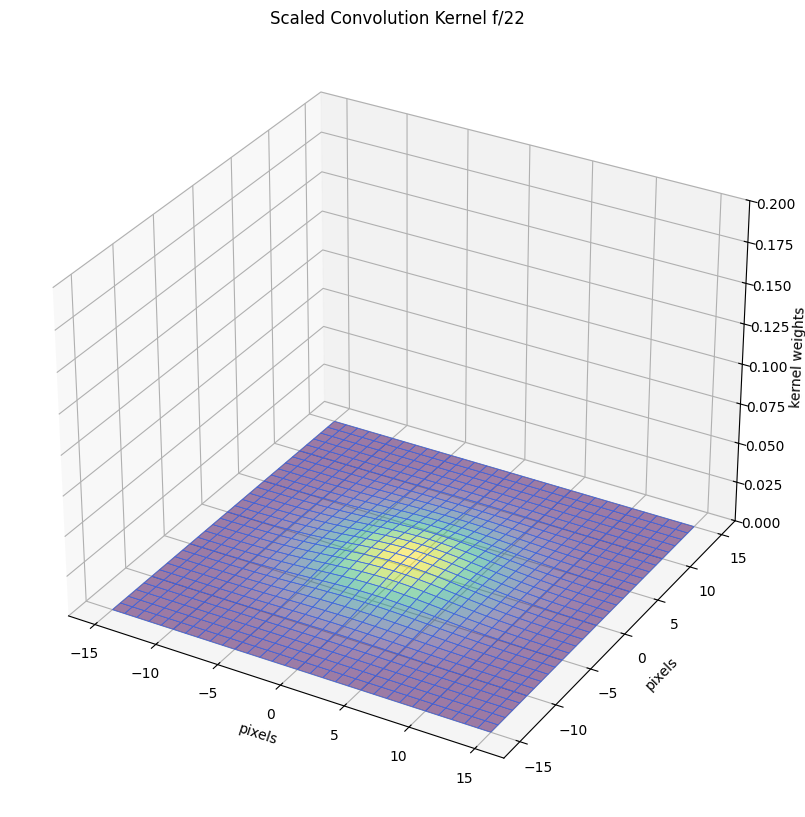

In [ ]:
# Display curve-fit
fig = plt.figure(figsize=(10,16))
ax = plt.axes(projection="3d")

# Plot the 3D surface
ax.plot_surface(x_grid, y_grid, scaled_kernel,
                edgecolor='royalblue', lw=0.5, rstride=1, cstride=1, alpha=0.5,
                cmap="viridis")

ax.set_zlim([0,0.2])
ax.set_title("Scaled Convolution Kernel f/22")
ax.set_xlabel("pixels")
ax.set_ylabel("pixels")
ax.set_zlabel("kernel weights")

plt.show

In [ ]:
print(chart_2000.dtype)
print(scaled_kernel.dtype)

uint8
float64


In [ ]:
# Match dtype
chart_2000 = chart_2000.astype(scaled_kernel.dtype)

# Convolve in 2 dimensions
convolved_hires_chart = cv.filter2D(chart_2000, cv.CV_64F, scaled_kernel)

# Check output is same size as input
assert convolved_hires_chart.shape == chart_2000.shape

In [ ]:
# Downscale output image using bicubic interpolation such that vertical size is same as original
# Sanity/value check
print(convolved_hires_chart.shape)
print(registered_iso_chart.shape)
print("Width = ", image_width, ", Height = ", image_height)
# Resize and confirm
convolved_hires_chart = cv.resize(convolved_hires_chart, (image_width, image_height), interpolation=cv.INTER_CUBIC)
print(convolved_hires_chart.shape)

(2000, 3552)
(561, 1058)
Width =  1058 , Height =  561
(561, 1058)


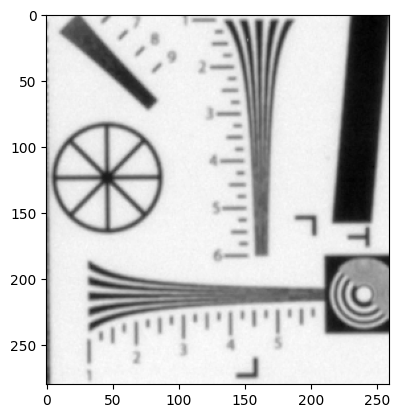

In [ ]:
plt.imshow(registered_iso_chart[90:370,290:550], cmap=mpl.colormaps['gray'])

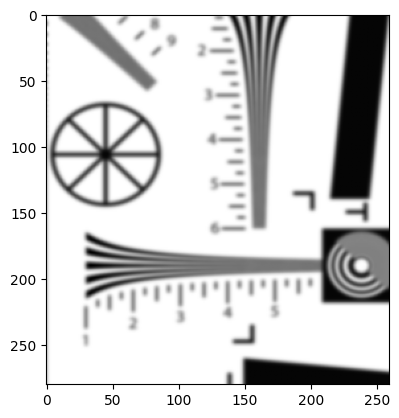

In [ ]:
plt.imshow(convolved_hires_chart[90:370,290:550], cmap=mpl.colormaps['gray'])